In [1]:
import sys
import torch
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
import matplotlib.pyplot as plt



# Add the project root directory (change '..' as needed!)
sys.path.append(str(Path().resolve().parent))  
from src.flf2v import LungCTFLF2V
from src.flf2v.lungct_vae import LungCTVAE
from src.flf2v.lungct_dit import create_dit_model
from src.flf2v.lungct_flow_matching import create_flow_matching_model



In [2]:

# ---- Paths ----
METADATA_CSV = "/home/ubuntu/flowmotion/splits/metadata.csv"
BEST_MODEL_PATH = "/home/ubuntu/azureblob/output/flf2v_8xa100_20250730_003014/best_model.pt"  # Adjust to your model location

# ---- Load metadata ----
df = pd.read_csv(METADATA_CSV, header=None)
df.columns = ["patient_id", "split", "experiment", "series_id", "slice_num", "phase_range", 
              "input_frames_path", "target_frames_path", "metadata_path", "input_shape",
              "target_shape", "input_dtype", "target_dtype"]

# ---- Filter for test split ----
test_df = df[df['split'] == 'test'].reset_index(drop=True)
print(f"Total test samples: {len(test_df)}")

Total test samples: 498


In [3]:
# ---- Pick a test sample ----
row = test_df.iloc[0]   # Change index as needed

input_frames = np.load(row['input_frames_path'])  # [10, H, W]
metadata = row['metadata_path']
with open(metadata, "r") as f:
    import json
    meta = json.load(f)

# ---- Pick phase 0 and phase 50 ----
phase_0 = input_frames[0]
phase_50 = input_frames[5]

# ---- Preprocess to torch tensors ----
first = torch.from_numpy(phase_0).float().unsqueeze(0).unsqueeze(0)  # [1,1,H,W]
last  = torch.from_numpy(phase_50).float().unsqueeze(0).unsqueeze(0) # [1,1,H,W]


In [4]:
# Use the same window as your config.yaml or training script!
WINDOW_MIN = -1000
WINDOW_MAX = 500

def window_and_normalize(image, window_min=WINDOW_MIN, window_max=WINDOW_MAX):
    image = np.clip(image, window_min, window_max)
    image = 2.0 * (image - window_min) / (window_max - window_min) - 1.0  # [-1,1]
    return image.astype(np.float32)

first_norm = window_and_normalize(phase_0)
last_norm  = window_and_normalize(phase_50)

first = torch.from_numpy(first_norm).float().unsqueeze(0).unsqueeze(0)
last  = torch.from_numpy(last_norm).float().unsqueeze(0).unsqueeze(0)

In [5]:
# 1. Load inference config from YAML
with open("/home/ubuntu/flowmotion/configs/config_inference.yaml", "r") as f:
    inference_config = yaml.safe_load(f)

# 2. Load checkpoint, but only use model_state_dict and not its config
checkpoint = torch.load(BEST_MODEL_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu")

# 3. Construct model with inference config
vae = LungCTVAE(
    base_model_name=inference_config['model']['vae_base_model'],
    latent_channels=inference_config['model']['latent_channels'],
    temporal_weight=inference_config['model']['vae_temporal_weight'],
    use_tanh_scaling=True,
    freeze_pretrained=False
)
dit = create_dit_model(inference_config['model']['dit_config'])
flow_matching = create_flow_matching_model({'config': inference_config['model']['flow_matching_config']})

model = LungCTFLF2V(
    vae=vae,
    dit=dit,
    flow_matching=flow_matching,
    freeze_vae_after=inference_config['model']['freeze_vae_after'],
    loss_weights=inference_config.get('training', {})  # Not needed for inference, but safe to supply
)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 1, 128, 128) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from /home/ubuntu/.cache/huggingface/hub/models--stanfordmimi--MedVAE/snapshots/8040c5ccb7a51eff6b4cef513c7f20bd1bda983d/model_weights/vae_4x_1c_2D.ckpt with 0 missing and 0 unexpected keys


In [6]:
def decode_in_chunks(vae, latent_video, chunk_size=2):
    B, C, T, h, w = latent_video.shape
    outs = []
    for start in range(0, T, chunk_size):
        end = min(start + chunk_size, T)
        chunk = latent_video[:, :, start:end, :, :]
        out = vae.decode(chunk)
        outs.append(out)
    return torch.cat(outs, dim=2)

# --- Run the FLF2V model to generate interpolated video ---
device = "cuda" if torch.cuda.is_available() else "cpu"
first = first.to(device)
last = last.to(device)

with torch.no_grad():
    latent_video = model.generate(
        first,
        last,
        num_frames=41,
        decode=False,
        progress_bar=True
    )  
    generated_video = decode_in_chunks(model.vae, latent_video, chunk_size=1)



🎬 Generating 41 frames
   Input shapes: first=torch.Size([1, 1, 1, 512, 512]), last=torch.Size([1, 1, 1, 512, 512])
   Latent shapes: first=torch.Size([1, 6, 1, 128, 128]), last=torch.Size([1, 6, 1, 128, 128])


Sampling:   0%|          | 0/20 [00:00<?, ?it/s]/home/ubuntu/flowmotion/src/flf2v/lungct_flow_matching.py:211: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
Sampling: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


✅ Sampling completed. Final shape: torch.Size([1, 6, 41, 128, 128])
   Generated latent: torch.Size([1, 6, 41, 128, 128])


In [7]:
def unnormalize(image, window_min=WINDOW_MIN, window_max=WINDOW_MAX):
    return ((image + 1) / 2) * (window_max - window_min) + window_min

gen_np = generated_video.cpu().numpy()[0,0]  # [T, H, W]
gen_np_vis = unnormalize(gen_np)


In [8]:
print("Input phase 0: min/max =", phase_0.min(), phase_0.max())
print("Input phase 50: min/max =", phase_50.min(), phase_50.max())
print("Generated frame 0: min/max =", gen_np[0].min(), gen_np[0].max())
print("Generated frame 20: min/max =", gen_np[20].min(), gen_np[20].max())
print("Generated frame 40: min/max =", gen_np[40].min(), gen_np[40].max())


Input phase 0: min/max = -6105 10489
Input phase 50: min/max = -6246 9950
Generated frame 0: min/max = 0.018081872 0.5190481
Generated frame 20: min/max = -0.5260238 0.75619936
Generated frame 40: min/max = 0.013722444 0.50805634


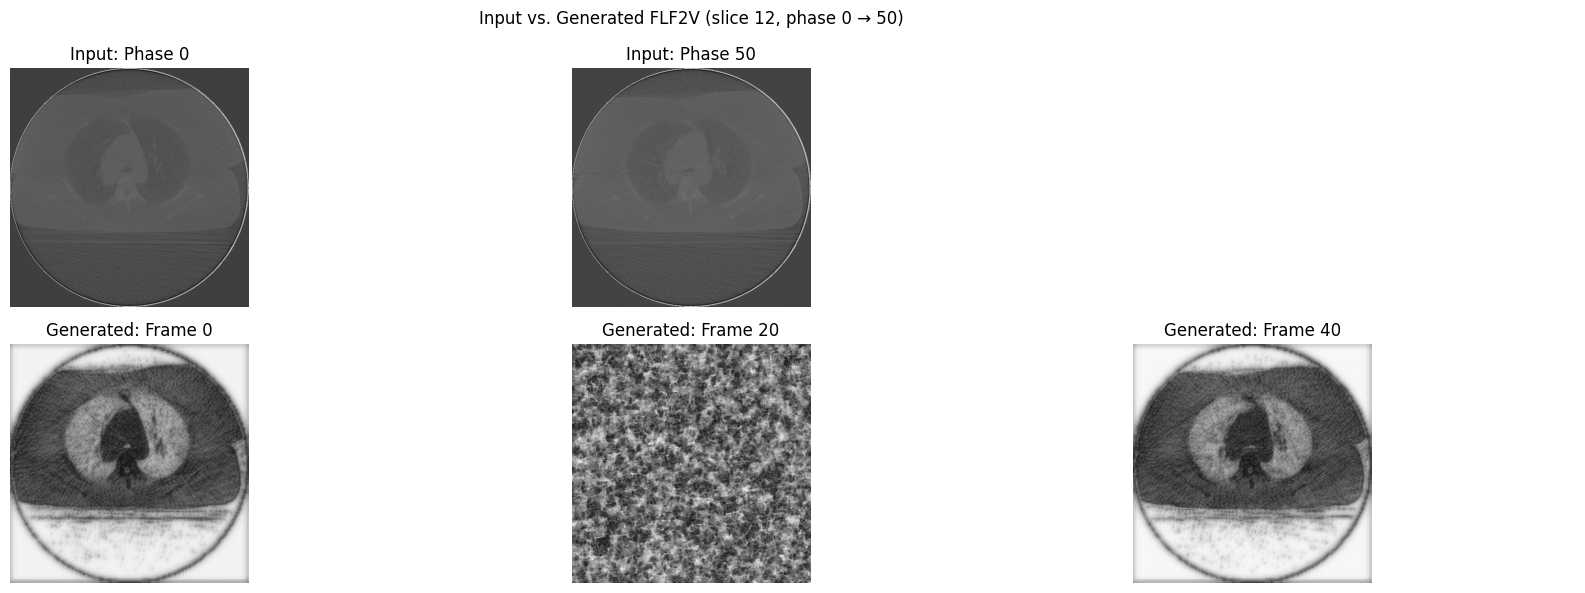

In [9]:
# --- Visualization: Input (phase 0, 50) + Generated (0, mid, 40) ---

gen_np = generated_video.cpu().numpy()[0,0]   # [T, H, W]

plt.figure(figsize=(18, 6))

# Input: phase 0
plt.subplot(2, 3, 1)
plt.imshow(phase_0, cmap='gray')
plt.title("Input: Phase 0")
plt.axis("off")

# Input: phase 50
plt.subplot(2, 3, 2)
plt.imshow(phase_50, cmap='gray')
plt.title("Input: Phase 50")
plt.axis("off")

# Empty plot for spacing
plt.subplot(2, 3, 3)
plt.axis("off")

# Generated: frame 0
plt.subplot(2, 3, 4)
plt.imshow(gen_np[0], cmap='gray')
plt.title("Generated: Frame 0")
plt.axis("off")

# Generated: mid-frame
mid_idx = gen_np.shape[0] // 2
plt.subplot(2, 3, 5)
plt.imshow(gen_np[mid_idx], cmap='gray')
plt.title(f"Generated: Frame {mid_idx}")
plt.axis("off")

# Generated: last frame (frame 40)
plt.subplot(2, 3, 6)
plt.imshow(gen_np[-1], cmap='gray')
plt.title(f"Generated: Frame {gen_np.shape[0]-1}")
plt.axis("off")

plt.suptitle("Input vs. Generated FLF2V (slice 12, phase 0 → 50)")
plt.tight_layout()
plt.show()


In [10]:
print("Input phase0 min/max", phase_0.min(), phase_0.max())
print("Generated frame 0 min/max", gen_np[0].min(), gen_np[0].max())


Input phase0 min/max -6105 10489
Generated frame 0 min/max 0.018081872 0.5190481
